# CatBoost(XGBoost) Analysis

In [1]:
import pandas as pd
import catboost
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None

## Load Data

In [2]:
df = pd.read_csv('data_preop_preprocessed.csv')
df.head()

,caseid,age,sex,bmi,asa,emop,anedur,los_postop,los_icu,death_inhosp,preop_htn,preop_dm,preop_arrhythmia,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,intraop_epi,intraop_ca,WBC,Hb,PLT,Albumin,GOT (AST),GPT (ALT),Creatinine,Sodium,Potassium,Chloride,hs-CRP quantitation,PT (INR),aPTT,Fibrinogen,pH,pCO₂,pO₂,HCO3-,BE,Calcium,Glucose,Lactic acid
0,1,77.0,1,26.3,2.0,0,180,8,0,0,1,0,0,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,3.1,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,54.0,1,19.6,2.0,0,245,19,0,0,0,0,0,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,0,0,4.36,10.2,251.0,NaN,NaN,NaN,NaN,143.0,4.7,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,62.0,1,24.4,1.0,0,65,2,0,0,0,0,0,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,74.0,1,20.5,2.0,0,335,7,1,0,1,0,0,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,4.3,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,66.0,1,20.4,3.0,1,350,45,13,0,1,0,1,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,0,2100,14.64,15.3,158.0,4.6,64.0,30.0,1.83,139.0,4.9,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9,140.0,NaN


In [3]:
X = df.drop(columns=['caseid', 'death_inhosp', 'anedur', 'los_postop', 'los_icu', 'asa'])
y = df['death_inhosp']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1004, stratify=y)

## Simple CatBoost Classifier

In [5]:
model = catboost.CatBoostClassifier(iterations=500, learning_rate=0.03, task_type='GPU')

In [6]:
model.fit(X=X_train, y=y_train, cat_features=['preop_pft'], verbose=0)

## Metric

In [7]:
## Accuracy
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9472153880563632
0.9327073552425665


### ROC Curve with AUROC

AUROC: 0.799841358467824


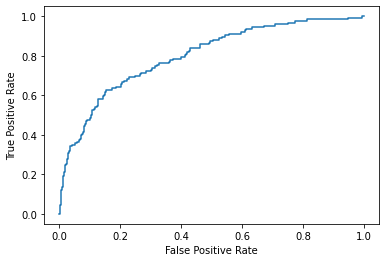

In [8]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test_proba = model.predict_proba(X_test)
print("AUROC: {}".format(roc_auc_score(y_test, y_test_proba[:, 1])))

fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1], pos_label=model.classes_[1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### Precision Recall Curve with AUPRC

AUPRC: 0.2897512069499642


<Figure size 720x720 with 0 Axes>

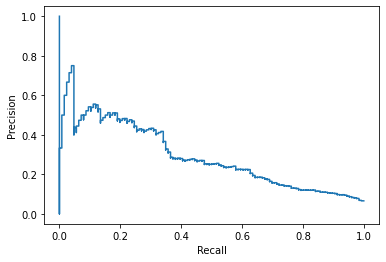

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

print("AUPRC: {}".format(average_precision_score(y_test, y_test_proba[:, 1])))

prec, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=model.classes_[1])

plt.figure(figsize=(10,10))
PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.show()

## Feature Importance

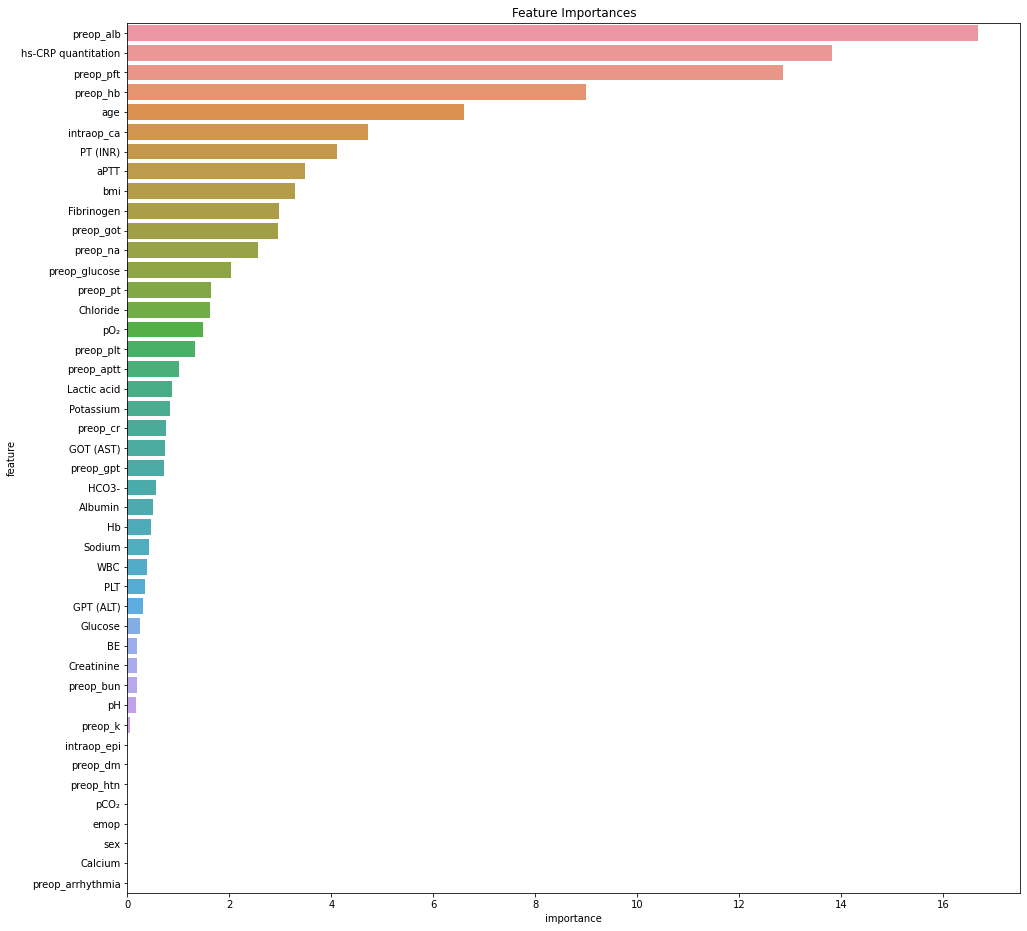

In [10]:
tmp = pd.DataFrame(model.feature_importances_, model.feature_names_, columns=['importance'])
tmp.index = tmp.index.set_names(['feature'])
tmp = tmp.reset_index()

plt.figure(figsize=(16, 16))
sns.barplot(data=tmp.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances')
plt.show()